In this assignment, we are trying to better understand NO2 emissions from Paris, using Sentinel-5P TROPOMI sensor, following a simplified version of Lorente et al. 2019 and de Foy et al. 2014.

Dataset:

*   Daily NO2 troposheric column density retrieved from Sentinel5P OFFL/L3_NO2 dataset
*   Daily wind speed (u and v) components from ERA5


#Task #1: Building NO2 density lines

For every single day of the dataset, we are willing to build a NO2 density line along wind direction between -30km (upwind) and 30km (downwind), centered on Paris center (48.8566° N, 2.3522° E). For each point along this line, the NO2 density is defined as the integration (sum) of NO2 column density perpendicular to the wind direction over a 60km interval (similar to Lorente et al. 2019).

Please generate one csv per day with distance and density information, as well as accompanying line plots. NA values in the remote sensing data should simply be ignored.


## Set up environment

In [1]:
!pip install rasterio --quiet
!pip install geopandas --quiet
!pip install rioxarray --quiet

     |████████████████████████████████| 19.3 MB 51.7 MB/s 
     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 16.7 MB 294 kB/s 
     |████████████████████████████████| 6.3 MB 13.5 MB/s 
     |████████████████████████████████| 47 kB 2.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


This code was developed in google colab - the below section allows you use files from a personal google drive

In [2]:
#mount google drive
import os
from google.colab import drive
drive.mount('/CREA')
%cd "/CREA/MyDrive/202209_rs_assignment-master/202209_rs_assignment-master/data"

Mounted at /CREA
/CREA/MyDrive/202209_rs_assignment-master/202209_rs_assignment-master/data


Otherwise, set working directory to data folder

In [ ]:
import os
#replace ... with file path
os.chdir("/.../202209_rs_assignment-master/data")

In [3]:
#import modules
import rasterio as rio
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from rasterio.plot import show
from matplotlib import colors, cm
from shapely.geometry import Point
import rioxarray
import xarray
from optparse import OptionParser
from affine import Affine
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from pandas.core.sorting import decons_group_index

## List files

In [4]:
# List files in directory
file_list = os.listdir()
print(file_list)

['era5_paris_20200526.tif', 'era5_paris_20200601.tif', 'era5_paris_20200529.tif', 'era5_paris_20200530.tif', 'era5_paris_20200527.tif', 'era5_paris_20200531.tif', 'era5_paris_20200602.tif', 'era5_paris_20200528.tif', 'no2_paris_20200528.tif', 'no2_paris_20200526.tif', 'no2_paris_20200527.tif', 'no2_paris_20200530.tif', 'no2_paris_20200531.tif', 'no2_paris_20200529.tif', 'no2_paris_20200601.tif', 'no2_paris_20200602.tif', 'reproj.tif', 'rotated.tif', 'rotated_2110.tif', 'test_save_xarray.tif', 'rotated_xarray.tif', 'foo.png']


In [5]:
# Return list of dates in dataset for iterating through dates later on
date_list = [x[-12:-4] for x in file_list]
print(date_list)

['20200526', '20200601', '20200529', '20200530', '20200527', '20200531', '20200602', '20200528', '20200528', '20200526', '20200527', '20200530', '20200531', '20200529', '20200601', '20200602', 'reproj', 'rotated', 'ted_2110', 'e_xarray', 'd_xarray', 'foo']


# Open and explore the datasets

In [ ]:
# Open rasters
no2_dataset = rio.open('no2_paris_' + date_list[0] + '.tif')
era_dataset = rio.open('era5_paris_' + date_list[0] + '.tif')

In [ ]:
# Some general information
print("Number of bands: ", no2_dataset.count)
print("CRS: ", no2_dataset.crs)
print("Number of cells (y): ", no2_dataset.shape[0])
print("Number of cells (x): ", no2_dataset.shape[1])

Number of bands:  1
CRS:  EPSG:4326
Number of cells (y):  6708
Number of cells (x):  10087


In [ ]:
# Return pixel size in x and y directions
gt = no2_dataset.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
print("pixel size X: ", pixelSizeX)
print("pixel size Y: ", pixelSizeY)

pixel size X:  0.00026949458523585647
pixel size Y:  0.00026949458523585647


In [15]:
# Make point of Paris centre
df = {'city':['Paris'],'geometry':[Point(2.3522, 48.8566)]}
paris = gpd.GeoDataFrame(df, crs="EPSG:4326")

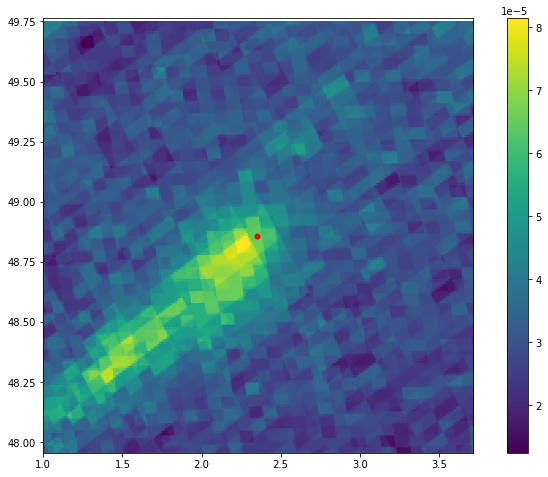

In [ ]:
# Plot NO2 data
fig, ax = plt.subplots(figsize=(12, 8))

#open raster in read mode
no2 = no2_dataset.read()
#plot raster
show((no2_dataset, 1), ax=ax, cmap='viridis')
#add paris point
paris.plot(color = 'red', markersize=25, ax=ax)
#add colorbar
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(no2), 
                                                     vmax=np.nanmax(no2)),
                                cmap='viridis'), ax=ax)#, shrink=0.4)

# Explore wind data

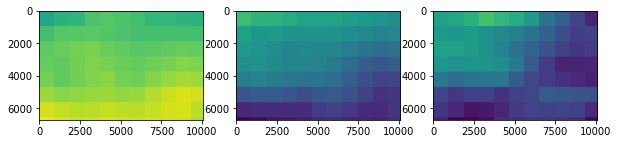

In [ ]:
##test and visualisation
u = era_dataset.read(1)
u = u[~np.isnan(u).all(axis=1)]
u_dims = u.shape
u_flat = u.flatten()
v = era_dataset.read(2)
v = v[~np.isnan(v).all(axis=1)]
v_flat = v.flatten()
dir_flat = np.select([(v_flat>0), (u_flat<0) & (v_flat<0), (u_flat>0) & (v_flat<0)],
                  [((180 / np.pi) * np.arctan(u_flat/v_flat) + 180), 
                   ((180 / np.pi) * np.arctan(u_flat/v_flat) + 0),
                   ((180 / np.pi) * np.arctan(u_flat/v_flat) + 360)])
dir = dir_flat.reshape(u_dims)

# Plot wind fields
fig, axes = plt.subplots(figsize=(10, 6), ncols=3)
ax0, ax1, ax2 = axes
ax0.imshow(dir)
ax1.imshow(u)
ax2.imshow(v)


# Define functions

In [6]:
# Define function for calculating average wind dirction
def calc_wind_dir(raster):

  u = era_dataset.read(1)
  u_dims = u.shape
  u_flat = u.flatten()
  v = era_dataset.read(2)
  v_flat = v.flatten()
  
  #calculate direction from u and v terms
  dir_flat = np.select([(v_flat>0), (u_flat<0) & (v_flat<0), (u_flat>0) & (v_flat<0)],
                  [((180 / np.pi) * np.arctan(u_flat/v_flat) + 180), 
                   ((180 / np.pi) * np.arctan(u_flat/v_flat) + 0),
                   ((180 / np.pi) * np.arctan(u_flat/v_flat) + 360)])
  
  dir = dir_flat.reshape(u_dims)
  dir = np.average(dir)
  return(dir)

## Downscale to 0.05 degree grid

In [28]:
# Define function for downscaling raster grid
def downscale_raster(dataset, outputRaster):
  gt = dataset.transform
  pixelSizeX = gt[0]
  pixelSizeY =-gt[4]
  
  rds = rioxarray.open_rasterio('no2_paris_' + x + '.tif').squeeze().drop("band")

  upscale_factor = 1/(0.05/pixelSizeX)
  new_width = int(rds.rio.width * upscale_factor)
  new_height = int(rds.rio.height * upscale_factor)

  rds_downscaled = rds.rio.reproject(
    rds.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear)

  rds_downscaled.rio.to_raster(
    outputRaster,
    tiled=True,
    windowed=True)

## Rotate 0.05 degree grid

code based on: https://gis.stackexchange.com/questions/418517/rotation-of-a-spatial-grid-by-an-angle-around-a-pivot-with-python-gdal-or-raster

In [8]:
# Define function to return the pixel coordinates of the raster center
def get_center_pixel(dataset):
    width, height = dataset.width, dataset.height
    # We calculate the middle of raster
    x_pixel_med = width // 2
    y_pixel_med = height // 2
    return (x_pixel_med, y_pixel_med)

In [9]:
# Define function to rotate the raster grid according to average wind direction angle
def rotate(source, angle, scale=1, outputRaster=None):
    outputRaster = 'rotated.tif' if outputRaster is None else outputRaster

    ### Read input
    assert source.crs == 'EPSG:4326', "Raster must have CRS=EPSG:4326, that is unprojected lon/lat (degree) relative to WGS84 datum"

    ### Rotate the affine about a pivot and rescale
    pivot = get_center_pixel(source)
    #print("\nPivot coordinates:", source.transform * pivot)

    # this is a 3D numpy array, with dimensions [band, row, col]
    data = source.read(masked=True)

    new_transform = source.transform * Affine.rotation(angle, pivot) * Affine.scale(scale)

    kwargs = source.meta
    kwargs['transform'] = new_transform

    with rio.open(outputRaster, 'w', **kwargs) as dst:
        for i in range(1, source.count + 1):
            reproject(
                source=rio.band(source, i),
                destination=rio.band(dst, i),
                src_transform=source.transform,
                src_crs=source.crs,
                dst_transform=new_transform,
                dst_crs=dst.crs,
                resampling=Resampling.average)
    return

In [53]:
# Define function to clip to 60km window
def clip_window(rotated_filepath, POI_x, POI_y, N):
  rotated = rio.open(rotated_filepath)
  py, px = rotated.index(POI_x, POI_y)

  # Build an NxN window
  window = rio.windows.Window(px - N//2, py - N//2, N, N)
  #print(window)

  # Read the data in the window
  # clip is a nbands * N * N numpy array
  clip = rotated.read(window=window)

  line_density = np.sum(clip, axis=2)
  dens = pd.Series(line_density.ravel(), name='line_density')

  #convert from units to molecules/cm (unknown conversion factor a)
  #dens = dens * (a)

  km = pd.Series((dens.index+1)*5, name='km')

  ld = pd.concat([km, dens], axis=1)

  #save csv
  ld.to_csv(("outputs/" + x + "_ld_series.csv"), index=False)
  #return series
  return ld

In [51]:
def plot_ld(series):
  fig, ax = plt.subplots(figsize=(12, 7))
  ax.plot(series['km'], series['line_density'], color='black', marker='o', linestyle='dashed')
  ax.set_xlabel('km')
  ax.set_ylabel('NO2 line density [units]')
  plt.savefig(("outputs/" + x + '_density_plot.png'))

# Iterate through list of dates

Processing:  20200526


/usr/local/lib/python3.7/dist-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "



Pivot coordinates: (2.3563259060097126, 48.86071577618696)
Window(col_off=20, row_off=12, width=12, height=12)
Processing:  20200601


/usr/local/lib/python3.7/dist-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "



Pivot coordinates: (2.3563259060097126, 48.86071577618696)
Window(col_off=21, row_off=12, width=12, height=12)
Processing:  20200529


/usr/local/lib/python3.7/dist-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "



Pivot coordinates: (2.3563259060097126, 48.86071577618696)
Window(col_off=21, row_off=12, width=12, height=12)
Processing:  20200530


KeyboardInterrupt: ignored

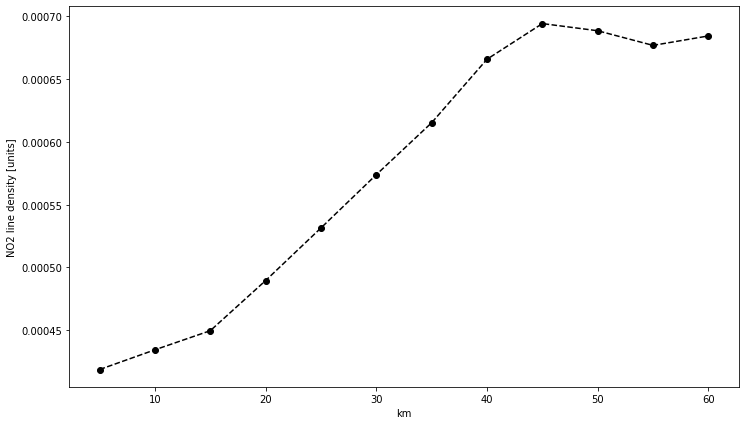

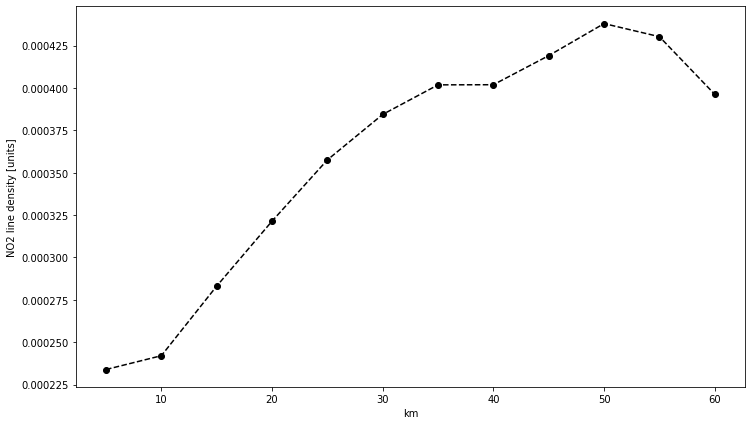

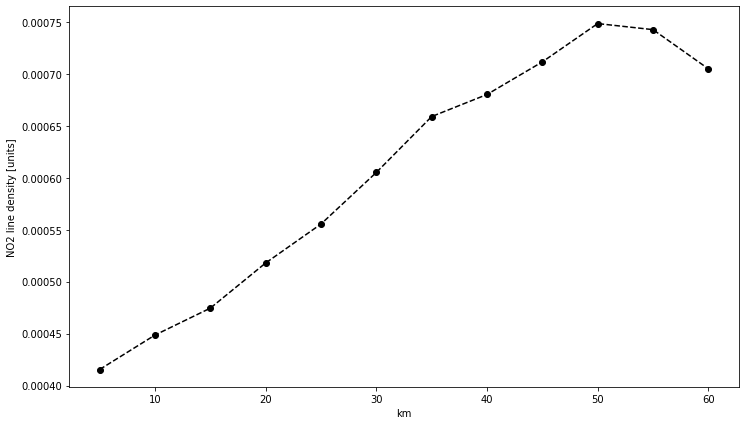

In [55]:
#create folder for outputs
newpath = r'outputs' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

for x in date_list:
  print("Processing: ", x)
  no2_dataset = rio.open('no2_paris_' + x + '.tif')
  era_dataset = rio.open('era5_paris_' + x + '.tif')
  
  #calculate average wind direction
  wind_dir = calc_wind_dir(era_dataset)
  #downscale raster
  downscale_raster(dataset=no2_dataset, outputRaster=(x+'_resampled.tif'))
  #rotate raster grid
  rotate(source=rio.open(x+'_resampled.tif'), angle=wind_dir, outputRaster=(x+'_rotated.tif'))
  #calculate line density for defined window, and save csv file
  ld_series = clip_window((x+'_rotated.tif'), POI_x=paris.geometry.x[0], POI_y=paris.geometry.y[0], N=12)
  #plot line density and save png of figure
  plot_ld(ld_series)

#Task #2: Estimating emissions
To extract some information from the NO2 density line, we will use the exponentially-modified gaussian approach defined in (de Foy et al. 2014, section 2.5).

This method suggests to fit the NO2 density line with the following function:

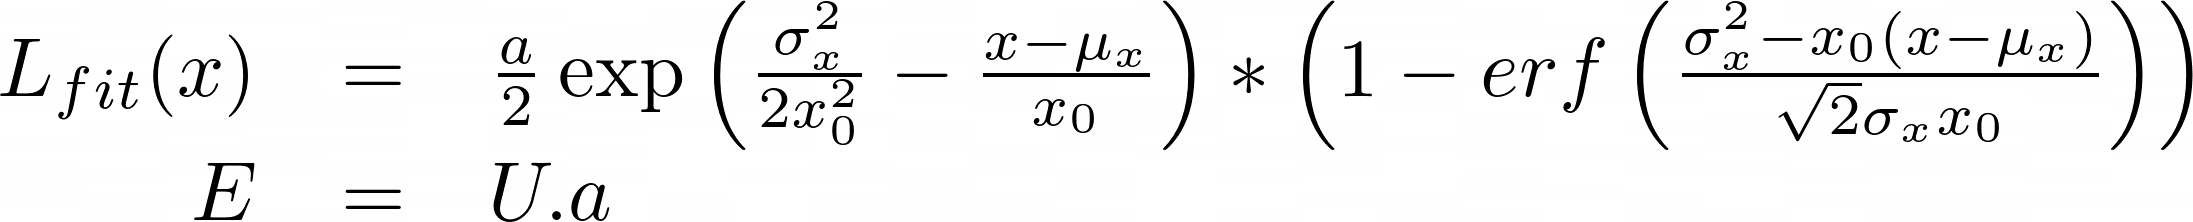

Lfit: the fitted version of the line density identified in previous task

E: NOx emission

U: wind speed

x - µx: position along the line density axis (x-µx)=0 in Paris

x0: length scale for chemical decay

For each day of the dataset, determine the optimal parameters a, x0 and σx and plot observed vs fitted density lines.

Can you say anything about NOx emissions during the selected days?

In [ ]:
#Possible functions to use:
#scipy.integrate.solve_ivp
#scipy.optimize.curve_fit

In [ ]:
#https://stackoverflow.com/questions/66031381/how-to-determine-unknown-parameters-of-a-differential-equation-based-on-the-best
#https://stackoverflow.com/questions/26163960/curve-fitting-with-a-known-function-numpy